<a href="https://colab.research.google.com/github/Tonnonssi/MNISTCUSTOM-CNN-Classifier/blob/master/04_TrainerCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *00.* Import

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#Basic
import os
import pickle
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import random
import PIL.Image

# 1_01. Load CUSTOM DATA Class, 02. Execute 
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

# 1_02. Net Class
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.pooling import MaxPool2d

# *01.* Classes

# -- Classes used in Data Setting part 

## 01 Load CUSTOM DATA Class

In [3]:
class CollectedDataset(Dataset):
    '''
    custom data can be divided into two types. 

    1. collected data : data collected by drawing nums. 
                        its arr has only 0,1 values 

    2. augmentated data : data augmentated by turning, expanding, or both. 
                          its arr has (0-1) values or (0-255: Astype uint8)

    Since I saved them divided, I have to load them seperated. 

    collected data and augmentated data are stored in self.data_list
    
    '''
    def __init__(self, collected_url=None, augmentated_url=None, transform=None):

        self.collected_data = self.download_files(collected_url)
        self.augmentated_data = self.download_files(augmentated_url)

        self.data_list = self.collected_data + self.augmentated_data

        self.transform = transform

    def download_files(self, data_url:str) -> list:
        if data_url == None:
            return []

        data_lst = []
        fnames = self.make_fname_lst(data_url)
        for fname in fnames:
            data = self.open_pickle_data(data_url+fname)
            tu_data = self.select_answerimage(data)
            data_lst.extend(tu_data)

        return data_lst

    def make_fname_lst(self, pre_url:str) -> list:
        fname_lst = os.listdir(pre_url)
        return fname_lst

    def open_pickle_data(self, url: str) -> list:
        with open(url, 'rb') as f:
            while True:
                try:
                    data = pickle.load(f)
                except EOFError:
                    break
        return data

    def select_answerimage(self, lst2d): 
        lst = []
        for data in lst2d:
            answer = data[0]
            img = data[2]
            
            if img.dtype == 'float64':
                img = (img *255).astype(np.uint8) #주의!
        
            if img.shape == (28, 28):
                image_new = np.expand_dims(img, axis=0) #sol1
                img = np.transpose(image_new, (1, 2, 0)) #sol2
                lst.append((img, answer))
            else:
                img= np.transpose(img, (1, 2, 0)) #sol2
                lst.append((img, answer))
            
        return lst

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        img = self.data_list[idx][0]
        label = self.data_list[idx][1]

        if self.transform:
            img = self.transform(img)
        else:
            torch.tensor(img).permute((2,0,1))
 
        return (img, label)

# -- Classes used in Training part 

## 02 Net Class

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.pooling import MaxPool2d

In [4]:
class Net(nn.Module):
    def __init__(self, bn=False):
        super().__init__()
        self.bn = bn

        self.conv1 = nn.Conv2d(1,10,5)
        self.conv2 = nn.Conv2d(10,20,5)

        self.pool = MaxPool2d(2,2)

        self.fc1 = nn.Linear(20*4*4, 100)
        self.fc2 = nn.Linear(100,10)

        #batch normalization
        self.bn1 = nn.BatchNorm2d(10)
        self.bn2 = nn.BatchNorm2d(20)

    def forward(self,x):
        if self.bn == True:
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
        else:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) #flat
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

## 03 Trainer Class

In [5]:
class Trainer:
    def __init__(self, fname, trainloader, testloader, epochs, net, bundle=100):
        self.fname = fname 

        self.trainloader = trainloader
        self.testloader = testloader

        self.net = net

        self.epochs = epochs
        self.criterian = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.net.parameters(), lr=0.001, momentum= 0.9)

        self.process_txt = ''

        self.bundle = bundle

        self.process()

    def train(self, dataloader, model, criterian, optimizer, t):

        start = time.time()

        running_loss = 0.0

        for batch, data in enumerate(dataloader, 1):
            inputs, labels = data

            optimizer.zero_grad()

            outputs  = model(inputs)
            loss = criterian(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch % self.bundle == 0:
                txt = f"[{t+1}, {batch}] loss: {running_loss /2000:.3f} --------------- {time.time()-start:.3f}\n"
                self.process_txt += txt
                print(txt)
                running_loss = 0.0  

    def test(self, dataloader, model, loss_fn):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        model.eval()
        test_loss, correct = 0.0, 0.0
        with torch.no_grad():
            for inputs, labels in dataloader:
                pred = model(inputs)
                test_loss += loss_fn(pred, labels).item()
                correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

            test_loss /= num_batches
            correct /= size
            txt = f"Test Error : \n Accuracy : {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
            self.process_txt += txt
            print(txt)

        self.correct = correct
        self.output_fname = f'{self.fname}_{(100*self.correct):>0.1f}%'
   
    def process(self):
        self.process_txt += f'Epochs : {self.epochs}\n'

        for t in range(self.epochs):
            txt = f"Epochs {t+1}\n-------------------------------\n"
            self.process_txt += txt
            print(txt)
            self.train(self.trainloader, self.net, self.criterian, self.optimizer,t)
            self.test(self.testloader, self.net, self.criterian)
        print('Done!')

## 04 SaveModel Class

In [6]:
class SaveModel:
    def __init__(self, output_fname, net, process_txt=None):
        self.output_fname = output_fname
        self.net = net
        self.process_txt = process_txt

        self.save_process()
        self.save_state()
        self.save_model()

    def save_process(self):
        fname = f'{self.output_fname}_process.txt'
        url = '/content/drive/MyDrive/MNISTandCustom/trained_model/process/'+fname
        f = open(url, 'w')
        f.write(self.process_txt)
        f.close()

    def save_state(self):
        fname = f'{self.output_fname}.pth'
        torch.save(self.net.state_dict(),'/content/drive/MyDrive/MNISTandCustom/trained_model/state/'+fname)
        print(f"Saved PyTorch Model State to '{fname}'")

    def save_model(self):
        fname = f'{self.output_fname}.pt'        
        torch.save(self.net, '/content/drive/MyDrive/MNISTandCustom/trained_model/model/'+fname)
        print(f"saved PyTorch Model to '{fname}'")

# -- Classes used in Testing part

## 05 TestModel Class

두 개 중에 뭐가 더 나은 방법론인지

In [ ]:
def load_pretrainedModel(file_location, net):
    loaded_state = torch.load(file_location)
    pretrained_model = net
    pretrained_model.load_state_dict(loaded_state)
    return pretrained_model

In [8]:
#ver1 pretrained model은 따로 함수로 이용

class TestModel:
    def __init__(self,dataloader,net):
        self.dataIter = iter(dataloader)
        self.net = net
    
    def eval_testdata(self):
        self.data_arr, label_arr = next(self.dataIter)
        self.net.eval()
        pred_arr = self.net(self.data_arr).argmax(1)
        self.pred_arr = np.array(pred_arr)
        self.label_arr = np.array(label_arr)

        self.df = pd.DataFrame({'pred': self.pred_arr, 'label': self.label_arr})
        return self.df

    def show_percentage(self):
        is_right = self.df['pred'] == self.df['label']
        return sum(is_right) / len(is_right)

In [73]:
#ver2 pretrained model이 같이 들어있는 클래스

class TestModel:
    def __init__(self,dataloader,net,net_location=None):
        self.dataIter = iter(dataloader)
        self.net = net
        if net_location:
            self.load_pretrainedModel(net_location)

    def load_pretrainedModel(self, net_location):
        loaded_state = torch.load(net_location)
        self.net.load_state_dict(loaded_state)
    
    def eval_testdata(self):
        self.data_arr, label_arr = next(self.dataIter)
        self.net.eval()
        pred_arr = self.net(self.data_arr).argmax(1)
        self.pred_arr = np.array(pred_arr)
        self.label_arr = np.array(label_arr)

        self.df = pd.DataFrame({'pred': self.pred_arr, 'label': self.label_arr})
        return self.df

    def show_percentage(self):
        is_right = self.df['pred'] == self.df['label']
        return sum(is_right) / len(is_right)

# *02.* Check Images

## 01 images datasets

- transform off

In [12]:
MNIST_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True) 
collected_trainset = CollectedDataset(collected_url = '/content/drive/MyDrive/MNISTandCustom/datafile/collected_data/') 
txpanded_trainset = CollectedDataset(augmentated_url = '/content/drive/MyDrive/MNISTandCustom/datafile/txpand/')
expanded_trainset = CollectedDataset(augmentated_url = '/content/drive/MyDrive/MNISTandCustom/datafile/expand/')
turn_trainset = CollectedDataset(augmentated_url = '/content/drive/MyDrive/MNISTandCustom/datafile/turn/')

100%|██████████| 9912422/9912422 [00:00<00:00, 88219079.28it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33370714.55it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20942586.85it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5824068.72it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



- transform on

In [13]:
MNIST_trainset_tf = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform= transforms.ToTensor()) 

collected_trainset_tf = CollectedDataset(collected_url = '/content/drive/MyDrive/MNISTandCustom/datafile/collected_data/',
                                      transform=transforms.ToTensor()) 
txpanded_trainset_tf = CollectedDataset(augmentated_url = '/content/drive/MyDrive/MNISTandCustom/datafile/txpand/',
                                     transform=transforms.ToTensor())
expanded_trainset_tf = CollectedDataset(augmentated_url = '/content/drive/MyDrive/MNISTandCustom/datafile/expand/',
                                     transform=transforms.ToTensor())
turn_trainset_tf = CollectedDataset(augmentated_url = '/content/drive/MyDrive/MNISTandCustom/datafile/turn/',
                                 transform=transforms.ToTensor())

## 02 print_images function, batch=4

In [9]:
def print_images(dataset,transform=False):
    fig, axs = plt.subplots(nrows=1, ncols=4)
    labels = []
    for i in range(4):
        img, label = dataset[random.randint(0,len(dataset))]
        if type(img) == PIL.Image.Image:
            img = np.array(img)
            img = np.expand_dims(img, axis=2) 

        if transform == False:
            img = torch.tensor(img).permute((2,0,1))
        axs[i].imshow(torchvision.utils.make_grid(img).permute(1,2,0))
        axs[i].set_title(label)
        labels.append(label)
    plt.show()
    

## 03 cases

### transform=False

- 한 번에 출력되는 코드

MNIST_trainset



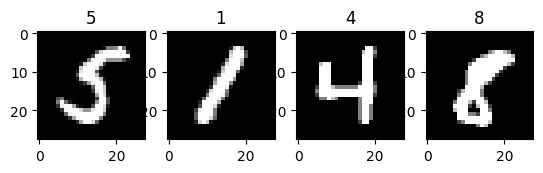


collected_trainset



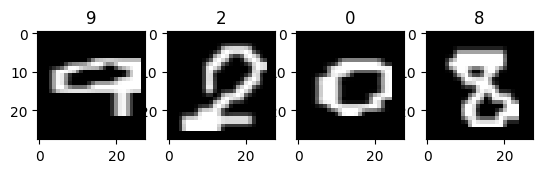


expanded_trainset



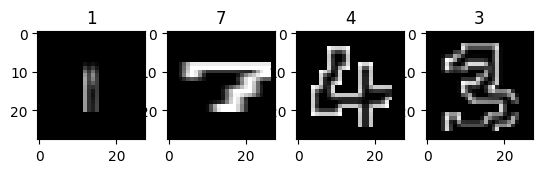


txpanded_trainset



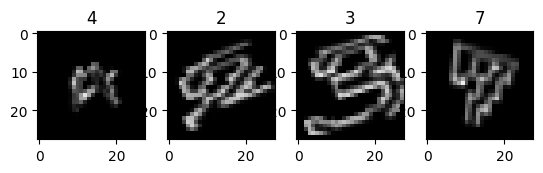


turn_trainset



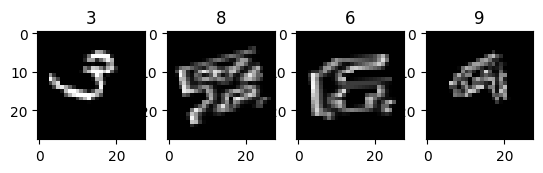

In [13]:
print('MNIST_trainset\n')
print_images(MNIST_trainset,transform=False)
print('\ncollected_trainset\n')
print_images(collected_trainset,transform=False)
print('\nexpanded_trainset\n')
print_images(expanded_trainset,transform=False)
print('\ntxpanded_trainset\n')
print_images(txpanded_trainset,transform=False)
print('\nturn_trainset\n')
print_images(turn_trainset,transform=False)

- 개별 출력 코드

In [ ]:
print_images(collected_trainset,transform=False)

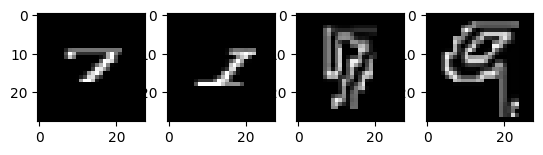

[7, 1, 7, 9]


In [20]:
print_images(expanded_trainset,transform=False)

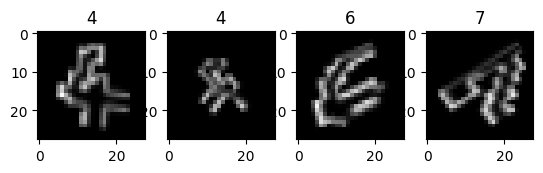

In [19]:
print_images(txpanded_trainset,transform=False)

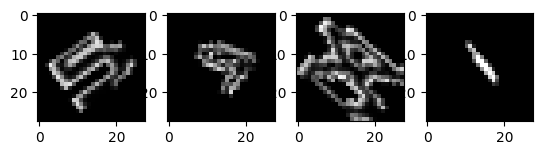

[5, 9, 8, 1]


In [50]:
print_images(turn_trainset,transform=False)

### transform=True

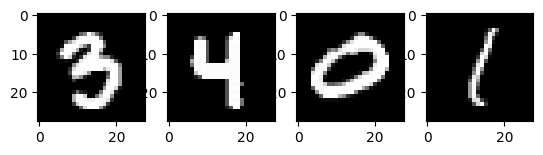

[3, 4, 0, 1]


In [45]:
print_images(MNIST_trainset_tf,transform=True)

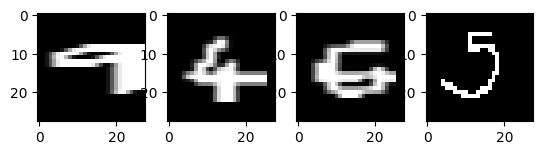

[9, 4, 6, 5]


In [215]:
print_images(collected_trainset_tf,transform=True)

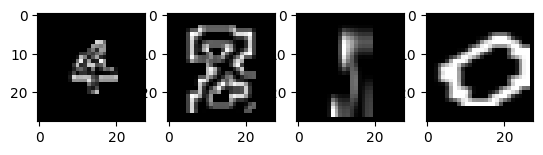

[4, 8, 1, 0]


In [202]:
print_images(expanded_trainset_tf,transform=True)

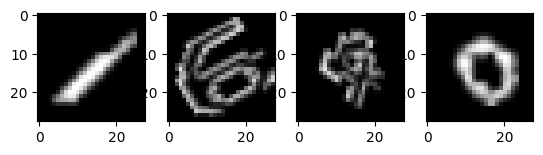

[1, 6, 4, 0]


In [48]:
print_images(txpanded_trainset_tf,transform=True)

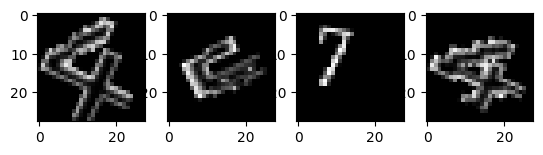

[4, 6, 7, 4]


In [47]:
print_images(turn_trainset_tf,transform=True)

# *03.* Execute

## 01 TrainSet / VaildSet / TestSet

### 1 Total Data Set

In [9]:
# Type of Data
# 1. MNIST 2. collected 3. augmented ( 3-1. txpanded 3-2. expanded 3-3. turn )

MNIST_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform= transforms.ToTensor()) 

collected_dataset = CollectedDataset(collected_url = '/content/drive/MyDrive/MNISTandCustom/datafile/collected_data/',
                                      transform=transforms.ToTensor()) 
txpanded_dataset = CollectedDataset(augmentated_url = '/content/drive/MyDrive/MNISTandCustom/datafile/txpand/',
                                     transform=transforms.ToTensor())
expanded_dataset = CollectedDataset(augmentated_url = '/content/drive/MyDrive/MNISTandCustom/datafile/expand/',
                                     transform=transforms.ToTensor())
turn_dataset = CollectedDataset(augmentated_url = '/content/drive/MyDrive/MNISTandCustom/datafile/turn/',
                                 transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 70710479.33it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 58294366.61it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25425697.40it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11387046.48it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
# Check for len

print(f'len of MNIST dataset : {len(MNIST_dataset)}')
print(f'len of collected dataset : {len(collected_dataset)}')
print(f'len of txpanded dataset : {len(txpanded_dataset)}')
print(f'len of expanded dataset : {len(expanded_dataset)}')
print(f'len of turn dataset : {len(turn_dataset)}')

len of MNIST dataset : 60000
len of collected dataset : 487
len of txpanded dataset : 7792
len of expanded dataset : 487
len of turn dataset : 7792


이거 판다스로 정리해두자

### 2 Select DataSet

In [11]:
dataSet = collected_dataset + txpanded_dataset + expanded_dataset + turn_dataset

### 3 Spilt to 3 sets


To make it easier to chage the ratio, I'll turn it into a function.
- 6:2:2
- 8:1:1

In [12]:
def spilt_data(dataset, train_per, vaild_per, test_per):
    train_size = int(len(dataset) * train_per)
    vaild_size = int(len(dataset) * vaild_per)
    test_size = len(dataset) - train_size - vaild_size
    return [train_size, vaild_size, test_size]

split

In [13]:
sizeList = spilt_data(dataSet, train_per=0.8, vaild_per = 0.1, test_per = 0.1)
trainSet, vaildSet, testSet = random_split(dataSet, sizeList)

In [14]:
# Check for len
print(f'len of dataset : {len(dataSet)}')
print(f'len of trainset : {len(trainSet)}')
print(f'len of vaildset : {len(vaildSet)}')
print(f'len of testset : {len(testSet)}')

len of dataset : 16558
len of trainset : 13246
len of vaildset : 1655
len of testset : 1657


## 02 TrainLoader / VaildLoader / TestLoader

In [15]:
batch_size = 32
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batch_size, shuffle=True, num_workers=2)
vaildLoader = torch.utils.data.DataLoader(vaildSet, batch_size=batch_size, shuffle=True, num_workers=2)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=batch_size, shuffle=True, num_workers=2)

## 03 Train 

### 1 

In [68]:
bn_net = Net(bn=True)

trainer = Trainer(fname='with_bn_modelCUSTOM',
                  trainloader=trainLoader, 
                  testloader=vaildLoader,
                  epochs=10,
                  net=bn_net)

save_model = SaveModel(output_fname = trainer.output_fname, 
                      net=trainer.net,
                      process_txt=trainer.process_txt)

Epochs 1
-------------------------------

[1, 100] loss: 0.113 --------------- 1.496

[1, 200] loss: 0.106 --------------- 2.877

[1, 300] loss: 0.099 --------------- 4.283

[1, 400] loss: 0.092 --------------- 5.664

Test Error : 
 Accuracy : 47.4%, Avg loss: 1.725819 

Epochs 2
-------------------------------

[2, 100] loss: 0.078 --------------- 1.356

[2, 200] loss: 0.063 --------------- 2.610

[2, 300] loss: 0.052 --------------- 4.544

[2, 400] loss: 0.047 --------------- 6.611

Test Error : 
 Accuracy : 69.7%, Avg loss: 0.909894 

Epochs 3
-------------------------------

[3, 100] loss: 0.039 --------------- 2.864

[3, 200] loss: 0.034 --------------- 4.571

[3, 300] loss: 0.030 --------------- 5.875

[3, 400] loss: 0.029 --------------- 7.166

Test Error : 
 Accuracy : 83.5%, Avg loss: 0.495905 

Epochs 4
-------------------------------

[4, 100] loss: 0.022 --------------- 1.342

[4, 200] loss: 0.021 --------------- 3.202

[4, 300] loss: 0.020 --------------- 5.252

[4, 400] l

# *04.* Test

## 01 recently trained model

In [69]:
dataiter = TestModel(dataloader=testLoader,net=trainer.net)

In [71]:
TFdf = dataiter.eval_testdata()

print(f' {TFdf[:16].T}')
print(' ')
print(TFdf[16:].T)
print(' ')
print(f'accuracy : {dataiter.show_percentage()}')

        0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15
pred    0   8   7   6   8   1   2   7   1   6   9   1   9   7   1   3
label   0   8   7   6   7   1   2   7   1   6   9   1   9   7   1   3
 
       16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31
pred    5   6   9   0   8   4   4   1   8   4   7   9   6   6   2   4
label   5   6   9   0   7   4   4   1   8   4   7   9   6   6   2   4
 
accuracy : 0.9375


## 02 Pretrained Model

이거 왜 st = net_structure.load_state_dict(loaded_state)에서 st랑 net_structure.load_state_dict(loaded_state)랑 데이터 타입이 다른걸까

In [78]:
#ver2 pretrained model이 같이 들어있는 클래스
net = Net(bn=True)
fileUrl = '/content/drive/MyDrive/MNISTandCustom/trained_model/state/with_bn_modelCUSTOM_96.9%.pth'

dataiter = TestModel(dataloader=testLoader,net=net,net_location=fileUrl)
TFdf = dataiter.eval_testdata()

print(f' {TFdf[:16].T}')
print(' ')
print(TFdf[16:].T)
print(' ')
print(f'accuracy : {dataiter.show_percentage()}')

        0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15
pred    9   4   6   2   4   7   2   8   0   6   7   7   3   1   7   9
label   9   4   6   2   4   7   2   8   0   6   7   7   3   1   7   9
 
       16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31
pred    7   0   8   8   4   6   8   9   6   0   5   2   0   7   6   0
label   7   0   8   8   4   6   8   9   6   0   5   2   0   7   6   0
 
accuracy : 1.0
